In [1]:
!pip install emoji
!pip install tweet-preprocessor
!pip install nltk
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 6.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [3]:
# Define the file paths in the Colab environment
file_path = '/content/Constraint_Train.csv'
val_file_path = '/content/Constraint_Val.csv'
test_file_path = '/content/Constraint_Test.csv'

try:
    # Load CSV datasets
    data = pd.read_csv(file_path)
    val_data = pd.read_csv(val_file_path)
    test_data = pd.read_csv(test_file_path)
    print("Datasets loaded successfully.")

    
except FileNotFoundError:
    print("File not found.")
except Exception as e:
    print("An unexpected error occurred:", e)

Datasets loaded successfully.


In [4]:
data['label_encoded'] = data['label'].apply(lambda x: 0 if x == 'real' else 1)
val_data['label_encoded'] = val_data['label'].apply(lambda x: 0 if x == 'real' else 1)

In [5]:
data.shape, val_data.shape

((6420, 4), (2140, 4))

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import preprocessor as p
import re

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Use tweet-preprocessor to remove URLs, mentions, hashtags, and emojis
    text = p.clean(text)

    # Remove punctuation except for numbers
    text = re.sub(r'[^\w\s\d]|_', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)

    return preprocessed_text

# Applying text preprocessing to the "tweet" column in both data and val_data
data['tweet'] = data['tweet'].apply(preprocess_text)
val_data['tweet'] = val_data['tweet'].apply(preprocess_text)

print("Preprocessed Data:")
print(data.head())

print("\nPreprocessed Validation Data:")
print(val_data.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Preprocessed Data:
   id                                              tweet label  label_encoded
0   1  cdc currently report death general discrepancy...  real              0
1   2  state reported death small rise last tuesday s...  real              0
2   3  politically correct woman almost us pandemic e...  fake              1
3   4    testing laboratory india th august test done dg  real              0
4   5  populous state generate large case count look ...  real              0

Preprocessed Validation Data:
   id                                              tweet label  label_encoded
0   1  chinese converting islam realising muslim affe...  fake              1
1   2  people diamond princess cruise ship intially t...  fake              1
2   3     covid19 caused bacterium virus treated aspirin  fake              1
3   4  mike penny rnc speech praise donald trump covi...  fake              1
4   5  10 sky explains latest data government announc...  real              0


In [7]:
data['tweet'] = data['tweet'].apply(preprocess_text)
val_data['tweet'] = val_data['tweet'].apply(preprocess_text)

In [8]:
# Tokenize and pad sequences
max_words = 10000
maxlen = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['tweet'])
X = tokenizer.texts_to_sequences(data['tweet'])
X = pad_sequences(X, maxlen=maxlen)

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, data['label_encoded'], test_size=0.2)

Epoch 1/25
161/161 [==============================] - 33s 178ms/step - loss: 0.3600 - accuracy: 0.8372 - val_loss: 0.1963 - val_accuracy: 0.9221
Epoch 2/25
161/161 [==============================] - 28s 177ms/step - loss: 0.1161 - accuracy: 0.9589 - val_loss: 0.1898 - val_accuracy: 0.9252
Epoch 3/25
161/161 [==============================] - 27s 166ms/step - loss: 0.0459 - accuracy: 0.9871 - val_loss: 0.2191 - val_accuracy: 0.9128
Epoch 4/25
161/161 [==============================] - 34s 213ms/step - loss: 0.0217 - accuracy: 0.9934 - val_loss: 0.2665 - val_accuracy: 0.9182
Epoch 5/25
41/41 [==============================] - 1s 34ms/step - loss: 0.1898 - accuracy: 0.9252
Test accuracy: 0.9252336621284485
67/67 [==============================] - 2s 33ms/step - loss: 0.2002 - accuracy: 0.9248
Validation accuracy: 0.9247663617134094


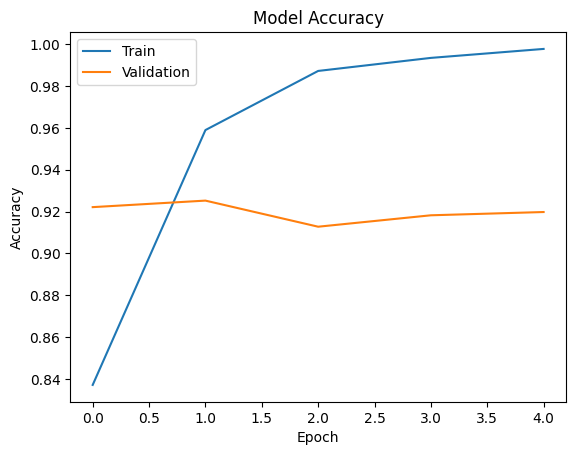

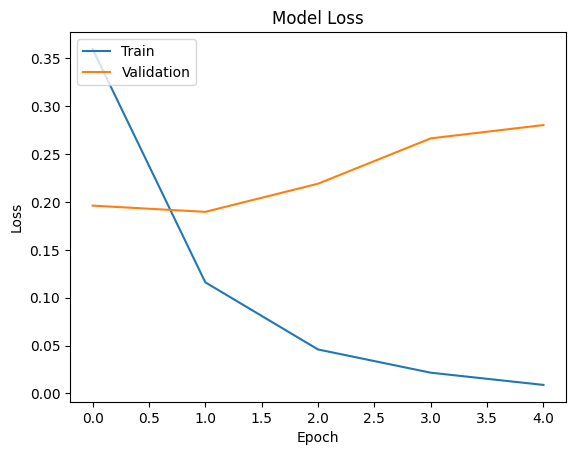

In [10]:
import matplotlib.pyplot as plt
# Build the model
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test),callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy)

# Preprocess text in val_data
val_data['tweet'] = val_data['tweet'].apply(preprocess_text)

# Tokenize and pad sequences for val_data
X_val = tokenizer.texts_to_sequences(val_data['tweet'])
X_val = pad_sequences(X_val, maxlen=maxlen)

# Evaluate the model on val_data
val_loss, val_accuracy = model.evaluate(X_val, val_data['label_encoded'])
print("Validation accuracy:", val_accuracy)

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
import numpy as np


true_labels = val_data['label_encoded']  
predicted_probabilities = model.predict(X_val) 

# Threshold the predicted probabilities to obtain binary predictions
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# Flatten the predicted labels array
predicted_labels_flattened = predicted_labels.flatten()

# Reshape the predicted labels array to match the shape of the true labels array
predicted_labels_reshaped = predicted_labels_flattened[:len(true_labels)]

# Compute true positives, false positives, false negatives
tp = np.sum((true_labels == 1) & (predicted_labels_reshaped == 1))
fp = np.sum((true_labels == 0) & (predicted_labels_reshaped == 1))
fn = np.sum((true_labels == 1) & (predicted_labels_reshaped == 0))

# Compute precision, recall, and F1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


67/67 [==============================] - 3s 33ms/step
Precision: 0.9102196752626552
Recall: 0.9343137254901961
F1 Score: 0.9221093372036768


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Save entire model
model.save('/content/drive/MyDrive/Bilstm.h5')

# Save weights only
model.save_weights('/content/drive/MyDrive/Bilstm_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
# Your input text
input_text = "Wearing a mask can cause a fungal infection."

# Preprocess the text
preprocessed_text = preprocess_text(input_text)

# Tokenize and pad the text
sequence = tokenizer.texts_to_sequences([preprocessed_text])
padded_sequence = pad_sequences(sequence, maxlen=maxlen)

# Load the model weights
model.load_weights("/content/drive/MyDrive/Bilstm_weights.h5")

prediction = model.predict(padded_sequence)

threshold = 0.8  # Adjust this based on your desired confidence level

print(input_text)

if prediction[0][0] < threshold:
    print("The text is classified : True")
else:
    print("The text is classified : False")

1/1 [==============================] - 0s 91ms/step
Wearing a mask can cause a fungal infection.
The text is classified : False
